# Submit pre-transpiled circuits

## Background

To get the best performance from your circuits, the Qiskit Runtime service will pass all circuits through Qiskit's transpiler before running them. While this is usually a good thing, we might sometimes want to disable this by passing the argument `skip_transpilation=True` to the primitive we're using.

For example, we may know better than the transpiler in some cases, or want to target a specific subset of qubits on a specific device. In this tutorial, we'll disable automatic transpilation to test the performance of different transpiler settings. This example will take you through the full process of creating, transpiling, and submitting circuits.

## Setup


In [41]:
# Create circuit to test transpiler on
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import GroverOperator, Diagonal

# Use Statevector object to calculate the ideal output
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, Sampler

In [43]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_hanoi'

## Step 1: Generate quantum circuits and operators.

In the following code cell, we create a small circuit that our transpiler will try to optimize. In this example, we create a circuit that carries out Grover's algorithm, with an oracle that marks the state `111`. We then simulate the ideal distribution (what we'd expect to measure if we ran this on a perfect quantum computer, an infinite number of times) for comparison later.


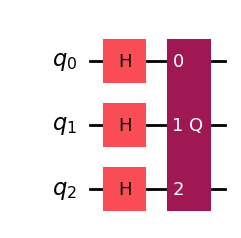

In [48]:
oracle = Diagonal([1] * 7 + [-1])
qc = QuantumCircuit(3)
qc.h([0, 1, 2])
qc = qc.compose(GroverOperator(oracle))

qc.draw(output="mpl", style="iqp")

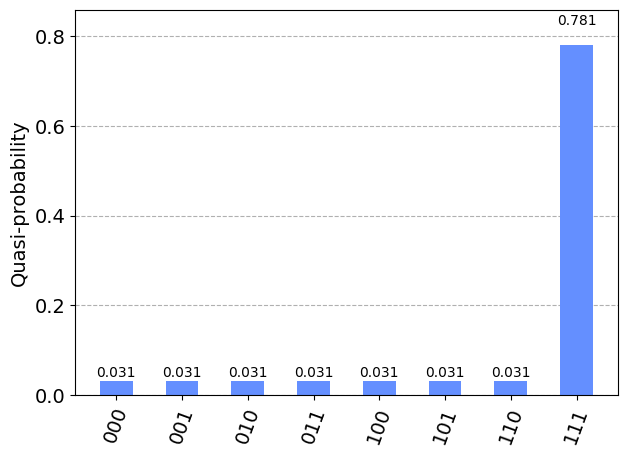

In [49]:
ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()

plot_histogram(ideal_distribution)

## Step 2: Optimize problem for quantum execution.

Next, we transpile the circuits for our backend. We're going to compare the performance of the transpiler with `optimization_level` set to `0` (lowest) against `3` (highest). The lowest optimization level just does the bare minimum needed to get the circuit running on the device; it maps the circuit qubits to the device qubits, and adds swaps gates to allow all 2-qubit operations. The highest optimization level is much smarter and uses lots of tricks to reduce the overall gate count. Since multi-qubit gates have high error rates, and qubits decohere over time, the shorter circuits should give better results.

In the following cell, we transpile `qc` for both values of `optimization_level`, print the number of CNOT gates, and add the transpiled circuits to a list. Some of the transpiler's algorithms are randomized, so we set a seed for reproducibility.


In [50]:
# Need to add measurements to the circuit
qc.measure_all()

circuits = []
for optimization_level in [0, 3]:
    t_qc = transpile(qc, backend, optimization_level=optimization_level, seed_transpiler=0)
    print(f"CNOTs (optimization_level={optimization_level}): ", t_qc.count_ops()["cx"])
    circuits.append(t_qc)

CNOTs (optimization_level=0):  27
CNOTs (optimization_level=3):  14


Since CNOTs usually have a high error rate, the circuit transpiled with `optimization_level=3` should perform much better.

Another way we can improve performance is through [dynamic decoupling](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-provider/qiskit_ibm_provider.transpiler.passes.scheduling.PadDynamicalDecoupling#paddynamicaldecoupling), where we apply a sequence of gates to idling qubits. This cancels out some unwanted interactions with the environment. In the following cell, we add dynamic decoupling to the circuit transpiled with `optimization_level=3`, and add it to our list.


In [51]:
from qiskit.transpiler import PassManager
from qiskit_ibm_runtime.transpiler.passes.scheduling import (
    ASAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.circuit.library import XGate

# Get gate durations so the transpiler knows how long each operation takes
durations = backend.target.durations()

# This is the sequence we'll apply to idling qubits
dd_sequence = [XGate(), XGate()]

# Run scheduling and dynamic decoupling passes on circuit
pm = PassManager([ASAPScheduleAnalysis(durations), PadDynamicalDecoupling(durations, dd_sequence)])
circ_dd = pm.run(circuits[1])

# Add this new circuit to our list
circuits.append(circ_dd)

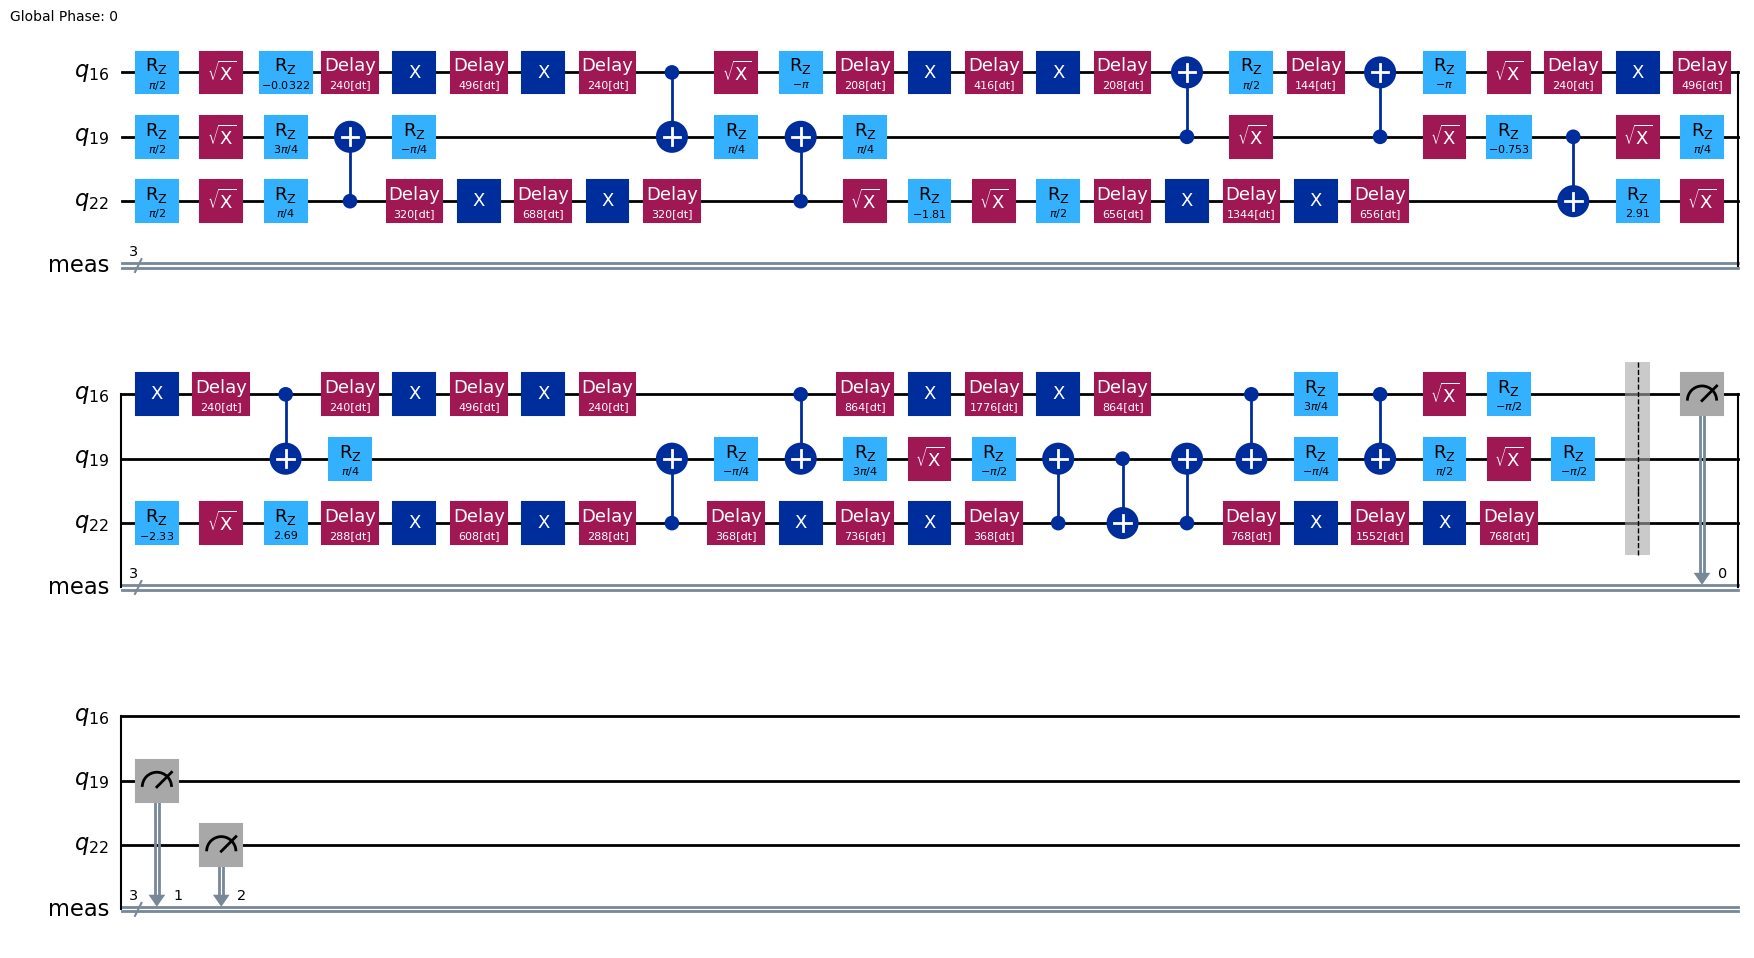

In [52]:
circ_dd.draw(output="mpl", style="iqp", idle_wires=False)

## Step 3: Execute using Qiskit Primitives.

At this point, we have a list of circuits transpiled for our system. In the following cell, we create an instance of the sampler primitive, and start a batched job using the context manager (`with ...:`), which automatically opens and closes the Batch for us. This is where we pass the `skip_transpilation=True` argument.

Within the context manager, we sample the circuits and store the results to `result`.


In [53]:
with Batch(service=service, backend=backend):
    sampler = Sampler()
    job = sampler.run(
        circuits=circuits,  # sample all three circuits
        skip_transpilation=True,
        shots=8000,
    )
    result = job.result()

## Step 4: Post-process, return result in classical format.

Finally, we can plot the results from the device runs against the ideal distribution. You can see the results with `optimization_level=3` are closer to the ideal distribution due to the lower gate count, and `optimization_level=3 + dd` is even closer due to the dynamic decoupling we applied.


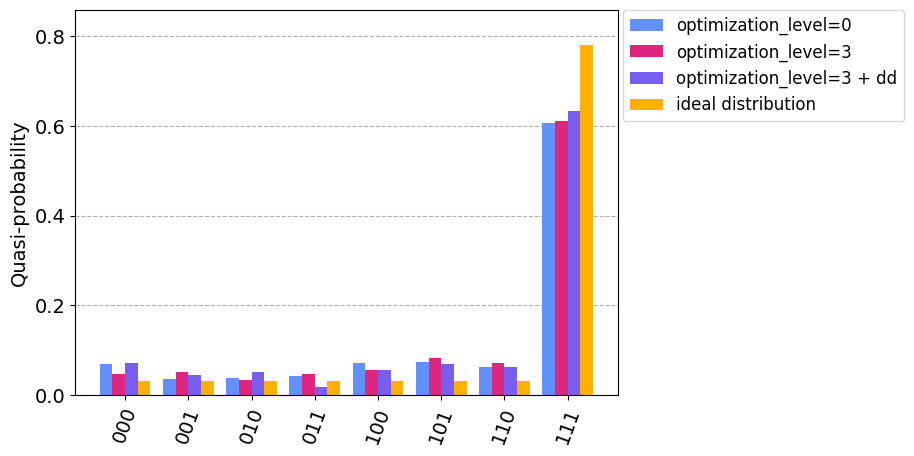

In [54]:
binary_prob = [quasi_dist.binary_probabilities() for quasi_dist in result.quasi_dists]
plot_histogram(
    binary_prob + [ideal_distribution],
    bar_labels=False,
    legend=[
        "optimization_level=0",
        "optimization_level=3",
        "optimization_level=3 + dd",
        "ideal distribution",
    ],
)

We can confirm this by computing the [Hellinger fidelity](https://docs.quantum-computing.ibm.com/api/qiskit/quantum_info) between each set of results and the ideal distribution (higher is better, and 1 is perfect fidelity).


In [57]:
from qiskit.quantum_info import hellinger_fidelity

for counts in result.quasi_dists:
    print(f"{hellinger_fidelity(counts.binary_probabilities(), ideal_distribution):.3f}")

0.958
0.961
0.963


In [56]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.15.0'

In [30]:
import qiskit

qiskit.version.get_version_info()

'0.45.0'